[Bag of Words Meets Bags of Popcorn](https://www.kaggle.com/c/word2vec-nlp-tutorial/data)
======

## Data Set

The labeled data set consists of 50,000 IMDB movie reviews, specially selected for sentiment analysis. The sentiment of reviews is binary, meaning the IMDB rating < 5 results in a sentiment score of 0, and rating >=7 have a sentiment score of 1. No individual movie has more than 30 reviews. The 25,000 review labeled training set does not include any of the same movies as the 25,000 review test set. In addition, there are another 50,000 IMDB reviews provided without any rating labels.

## File descriptions

labeledTrainData - The labeled training set. The file is tab-delimited and has a header row followed by 25,000 rows containing an id, sentiment, and text for each review.
## Data fields

* id - Unique ID of each review
* sentiment - Sentiment of the review; 1 for positive reviews and 0 for negative reviews
* review - Text of the review

## Objective
Objective of this dataset is base on **review** we predict **sentiment** (positive or negative) so X is **review** column and y is **sentiment** column

## Load Dataset and EDA

In [1]:
# Import necessary libraries
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import pickle
import os
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load dataset
data = pd.read_csv('./data/movie_review.csv', sep='\t', encoding='latin-1')

In [3]:
data.head()

,id,review,sentiment
0,5814_8,With all this stuff going down at the moment w...,1
1,2381_9,"\The Classic War of the Worlds\"" by Timothy Hi...",1
2,7759_3,The film starts with a manager (Nicholas Bell)...,0
3,3630_4,It must be assumed that those who praised this...,0
4,9495_8,Superbly trashy and wondrously unpretentious 8...,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22500 entries, 0 to 22499
Data columns (total 3 columns):
id           22500 non-null object
review       22500 non-null object
sentiment    22500 non-null int64
dtypes: int64(1), object(2)
memory usage: 527.4+ KB


In [5]:
data.drop(['id'], axis=1, inplace=True)

In [6]:
data.isnull().sum()

review       0
sentiment    0
dtype: int64

In [7]:
# how many possitive and negative labels?
data[data['sentiment'] == 1].count()

review       11278
sentiment    11278
dtype: int64

#### Classes distribution in the dataset

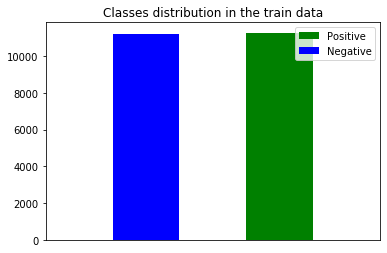

Positive: 11278 - Negative: 11222


In [8]:
# how many possitive and negative labels?
plt.hist(data[data.sentiment == 1].sentiment,
         bins=2, color='green', label='Positive')
plt.hist(data[data.sentiment == 0].sentiment,
         bins=2, color='blue', label='Negative')
plt.title('Classes distribution in the train data')
plt.xticks([data[data.sentiment == 1].sentiment.count(), data[data.sentiment == 0].sentiment.count()])
plt.xlim(-0.5, 2)
plt.legend()
plt.show()
print('Positive: {} - Negative: {}'.format(data[data.sentiment == 1].sentiment.count(), data[data.sentiment == 0].sentiment.count()))

In [9]:
# get a word count per sentence column
def word_count(sentence):
    return len(sentence.split())
    
data['word count'] = data['review'].apply(word_count)

In [10]:
data.head(5)

,review,sentiment,word count
0,With all this stuff going down at the moment w...,1,433
1,"\The Classic War of the Worlds\"" by Timothy Hi...",1,158
2,The film starts with a manager (Nicholas Bell)...,0,378
3,It must be assumed that those who praised this...,0,379
4,Superbly trashy and wondrously unpretentious 8...,1,367


#### Word count distribution

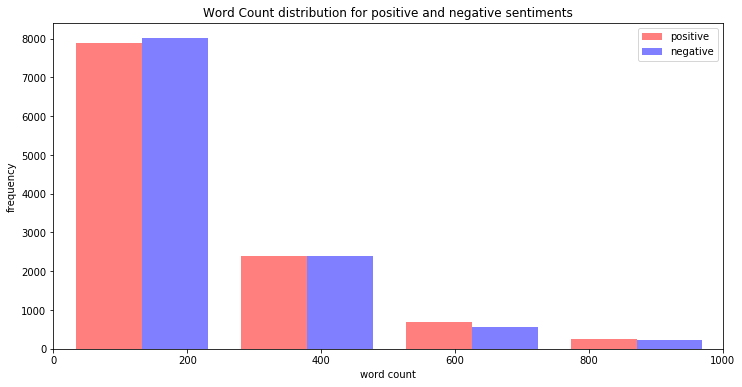

In [11]:
# plot word count distribution for both positive and negative sentiments
x = data['word count'][data.sentiment == 1]
y = data['word count'][data.sentiment == 0]
plt.figure(figsize=(12,6))
plt.xlim(0,1000)
plt.xlabel('word count')
plt.ylabel('frequency')
g = plt.hist([x, y], color=['r','b'], alpha=0.5, label=['positive','negative'])
plt.legend(loc='upper right')
plt.title("Word Count distribution for positive and negative sentiments")
plt.show()

#### Most common words 

In [12]:
# get most common words in training dataset
all_words = []
for line in list(data['review']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())


Counter(all_words).most_common(50)

[('the', 290182),
 ('a', 144051),
 ('and', 142724),
 ('of', 130112),
 ('to', 120539),
 ('is', 93742),
 ('in', 81699),
 ('i', 63363),
 ('this', 62661),
 ('that', 59553),
 ('it', 58825),
 ('/><br', 45851),
 ('was', 42295),
 ('as', 40642),
 ('for', 38520),
 ('with', 38406),
 ('but', 35782),
 ('on', 28508),
 ('movie', 27684),
 ('his', 26285),
 ('are', 25832),
 ('not', 25584),
 ('film', 25095),
 ('you', 24793),
 ('have', 24632),
 ('he', 23584),
 ('be', 23178),
 ('at', 20443),
 ('one', 20310),
 ('by', 19799),
 ('an', 19098),
 ('they', 18573),
 ('from', 17979),
 ('all', 17685),
 ('who', 17513),
 ('like', 16869),
 ('so', 16211),
 ('just', 15531),
 ('or', 15035),
 ('has', 14923),
 ('about', 14800),
 ('her', 14788),
 ("it's", 14312),
 ('some', 13700),
 ('if', 13657),
 ('out', 13071),
 ('what', 12602),
 ('when', 12313),
 ('very', 12244),
 ('more', 11843)]

## Preprocessing

In [13]:
# Get the list of stop words in English
from nltk.corpus import stopwords

# In Python, searching a set is much faster than searching
# a list, so convert the stop words to a set
stop_words = set(stopwords.words('english'))

# stop_words = ['the', 'a', 'and', 'of', 'to', 'is', 'in', 'i']

In [14]:
# Remove special characters, html tags and "trash"
def clean_text(text):
  # remove HTML markup
  text = re.sub('<[^>]*>', '', text)
  
  # Save emoticons for later appending
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
  # Now remove emoticons
  text = re.sub('(?::|;|=)(?:-)?(?:\)|\(|D|P)', '', text)
  
  # Remove some special characters
  text = re.sub('Ã\x82Â¨', '', text)
  
  # Save number in 1,000 or 1.000 formats for later appending
  numbers = re.findall(r'(?<!,)\b(\d{1,3}(?:[.,]\d{3})*)\b(?!,)', text)
  # Now remove numbers
  text = re.sub(r'(?<!,)\b(\d{1,3}(?:[.,]\d{3})*)\b(?!,)', '', text)
  
  # Remove any non-word character and append the emoticons,
  # removing the nose character for standardization. Convert to lower case
  text = (re.sub('[\W]+', ' ', text.lower()))
  
  # Remove words with 2 or fewer letters
#   text = re.sub(r'\b\w{1,2}\b', '', text)
  
  # Remove whitespace (including new line characters)
  text = re.sub(r'\s\s+', ' ', text)
  
  # Remove single space remaining.
  text = text.strip(' ') 
  
  # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
  text = ''.join(c for c in text if c <= '\uFFFF') 
  
  # rejoin emoticons & numbers
  text = text + ' ' + ' '.join(emoticons).replace('-', '') + ' ' + ' '.join(numbers).replace('.', '').replace(',', '')
  
  return text

  
# Tokenizer and Stemming
# tokenizer: to break down our twits in individual words
# stemming: reducing a word to its root
porter = PorterStemmer()

def preprocessor_stem(text):
  
  text = clean_text(text)
  # stemming
  text = [porter.stem(word) for word in text.split()]
  # Remove stop words
  text = [word for word in text if not word in stop_words]
  text = " ".join(text)
  return text
  
def tokenizer(text):
  return [word for word in text.split()]

In [15]:
# Test clean text
string = 'Yeah :-D I love loving loved loovveee this one so much him =) Ã\x82Â¨10.000 BC(2006)Ã\x82Â¨ !@#% Blah #()@...,<,<> Ã\x82Â¨Jurassik ParkÃ\x82Â¨'
string = clean_text(string)
print(string)

yeah i love loving loved loovveee this one so much him bc 2006 blah jurassik park :D =) 10000


In [16]:
# Test clean text with stemming
string_token = preprocessor_stem(string)
print(tokenizer(string_token))

['yeah', 'love', 'love', 'love', 'loovvee', 'thi', 'one', 'much', 'bc', '2006', 'blah', 'jurassik', 'park', '10000', ':D', '=)']


In [17]:
# data.drop(columns='stem processed review', inplace=True)
data.insert(loc = 1, column="stem processed review", value="")

In [18]:
data['stem processed review'] = data['review'].apply(preprocessor_stem)

In [19]:
data['stem processed review word count'] = data['stem processed review'].apply(word_count)

In [20]:
data.head()

,review,stem processed review,sentiment,word count,stem processed review word count
0,With all this stuff going down at the moment w...,thi stuff go moment mj start listen hi music w...,1,433,242
1,"\The Classic War of the Worlds\"" by Timothy Hi...",classic war world timothi hine veri entertain ...,1,158,92
2,The film starts with a manager (Nicholas Bell)...,film start manag nichola bell give welcom inve...,0,378,245
3,It must be assumed that those who praised this...,must assum prais thi film greatest film opera ...,0,379,200
4,Superbly trashy and wondrously unpretentious 8...,superbl trashi wondrous unpretenti exploit hoo...,1,367,223


### Create Train - Test Subsets

In [21]:
X = data['stem processed review']
y = data['sentiment']

In [22]:
t0 = time.time()
tfidf = TfidfVectorizer(tokenizer=tokenizer)
X_tfidf = tfidf.fit_transform(X)
t1 = time.time()

X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y, test_size=0.25, random_state=101)
t2 = time.time()

time_vectorizing = t1-t0
time_splitting = t2-t1

print("Vectorizing time: %fs; Train-Test Splitting time: %fs" % (time_vectorizing, time_splitting))

Vectorizing time: 2.778432s; Train-Test Splitting time: 0.045516s


In [23]:
X_train_tfidf.shape

(16875, 50642)

## Model training and evaluation
We will explore different classifiers to evaluate the most efficient one in term of accuracy and computational difficulty.

### Logistic Regression Classifier

In [24]:
lr = LogisticRegression()
t0 = time.time()

lr.fit(X_train_tfidf, y_train_tfidf)
t1 = time.time()

lr_preds = lr.predict(X_test_tfidf)
t2 = time.time()

time_linear_train = t1-t0
time_linear_predict = t2-t1

# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))

lr_cm = confusion_matrix(y_test_tfidf, lr_preds)
lr_report = classification_report(y_test_tfidf, lr_preds)

Training time: 0.856787s; Prediction time: 0.003536s


In [25]:
print(lr_cm)
print(lr_report)

[[2459  371]
 [ 258 2537]]
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      2830
           1       0.87      0.91      0.89      2795

    accuracy                           0.89      5625
   macro avg       0.89      0.89      0.89      5625
weighted avg       0.89      0.89      0.89      5625



### Decision Tree Classifier

In [26]:
dtc = DecisionTreeClassifier()
t0 = time.time()
dtc.fit(X_train_tfidf, y_train_tfidf)
t1 = time.time()

dtc_preds = dtc.predict(X_test_tfidf)
t2 = time.time()

time_dtc_train = t1-t0
time_dtc_predict = t2-t1

# results
print("Training time: %fs; Prediction time: %fs" % (time_dtc_train, time_dtc_predict))

dtc_cm = confusion_matrix(y_test_tfidf, dtc_preds)
dtc_report = classification_report(y_test_tfidf, dtc_preds)

Training time: 21.489758s; Prediction time: 0.038512s


In [27]:
print(dtc_cm)
print(dtc_report)

[[2012  818]
 [ 780 2015]]
              precision    recall  f1-score   support

           0       0.72      0.71      0.72      2830
           1       0.71      0.72      0.72      2795

    accuracy                           0.72      5625
   macro avg       0.72      0.72      0.72      5625
weighted avg       0.72      0.72      0.72      5625



### Random Forest Classifier

In [28]:
rfc = RandomForestClassifier()

t0 = time.time()
rfc.fit(X_train_tfidf, y_train_tfidf)
t1 = time.time()

rfc_preds = rfc.predict(X_test_tfidf)
t2 = time.time()

time_rfc_train = t1-t0
time_rfc_predict = t2-t1

# results
print("Training time: %fs; Prediction time: %fs" % (time_rfc_train, time_rfc_predict))

rfc_cm = confusion_matrix(y_test_tfidf, rfc_preds)
rfc_report = classification_report(y_test_tfidf, rfc_preds)

Training time: 5.204248s; Prediction time: 0.063081s


In [29]:
print(rfc_cm)
print(rfc_report)

[[2328  502]
 [ 882 1913]]
              precision    recall  f1-score   support

           0       0.73      0.82      0.77      2830
           1       0.79      0.68      0.73      2795

    accuracy                           0.75      5625
   macro avg       0.76      0.75      0.75      5625
weighted avg       0.76      0.75      0.75      5625



### K-Neighbors Nearest Classifier

In [30]:
knn = KNeighborsClassifier()

t0 = time.time()
knn.fit(X_train_tfidf, y_train_tfidf)
t1 = time.time()

knn_preds = knn.predict(X_test_tfidf)
t2 = time.time()

time_knn_train = t1-t0
time_knn_predict = t2-t1

# results
print("Training time: %fs; Prediction time: %fs" % (time_knn_train, time_knn_predict))

knn_cm = confusion_matrix(y_test_tfidf, knn_preds)
knn_report = classification_report(y_test_tfidf, knn_preds)

Training time: 0.015005s; Prediction time: 8.585220s


In [31]:
print(knn_cm)
print(knn_report)

[[2094  736]
 [ 456 2339]]
              precision    recall  f1-score   support

           0       0.82      0.74      0.78      2830
           1       0.76      0.84      0.80      2795

    accuracy                           0.79      5625
   macro avg       0.79      0.79      0.79      5625
weighted avg       0.79      0.79      0.79      5625



### Support Vector Machine Classifier

In [32]:
svm = SVC(kernel='linear')

t0 = time.time()
svm.fit(X_train_tfidf, y_train_tfidf)
t1 = time.time()

svm_preds = svm.predict(X_test_tfidf)
t2 = time.time()

time_svm_train = t1-t0
time_svm_predict = t2-t1

# results
print("Training time: %fs; Prediction time: %fs" % (time_svm_train, time_svm_predict))

svm_cm = confusion_matrix(y_test_tfidf, svm_preds)
svm_report = classification_report(y_test_tfidf, svm_preds)

Training time: 210.990225s; Prediction time: 40.653803s


In [33]:
print(svm_cm)
print(svm_report)

[[2473  357]
 [ 280 2515]]
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      2830
           1       0.88      0.90      0.89      2795

    accuracy                           0.89      5625
   macro avg       0.89      0.89      0.89      5625
weighted avg       0.89      0.89      0.89      5625



### Export Trained Models, default mode

In [34]:
# Using pickle to export our trained model
# pickle.dump(lr, open(os.path.join('models', 'Model_LR_default_imdb.pkl'), 'wb'), protocol=4)
# pickle.dump(dtc, open(os.path.join('models', 'Model_DTC_default_imdb.pkl'), 'wb'), protocol=4)
# pickle.dump(rfc, open(os.path.join('models', 'Model_RFC_default_imdb.pkl'), 'wb'), protocol=4)
# pickle.dump(knn, open(os.path.join('models', 'Model_KNN_default_imdb.pkl'), 'wb'), protocol=4)
# pickle.dump(svm, open(os.path.join('models', 'Model_SVM_default_imdb.pkl'), 'wb'), protocol=4)

## 4. Performance Comparison

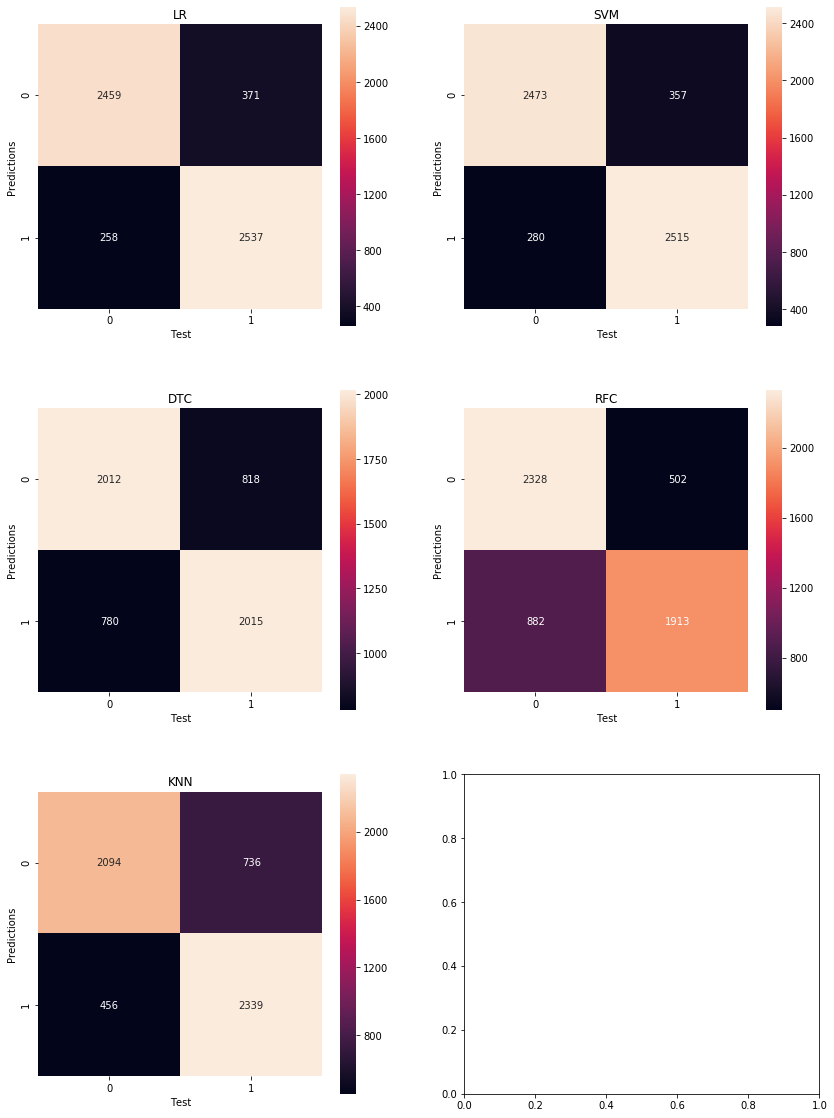

In [35]:
fig, ax = plt.subplots(3,2, figsize=[14,20])

sns.heatmap(lr_cm, ax=ax[0, 0], annot=True, fmt='d', square=True)
ax[0, 0].set_title('LR')
ax[0, 0].set_xlabel('Test')
ax[0, 0].set_ylabel('Predictions')

sns.heatmap(svm_cm, ax=ax[0, 1], annot=True, fmt='d', square=True)
ax[0, 1].set_title('SVM')
ax[0, 1].set_xlabel('Test')
ax[0, 1].set_ylabel('Predictions')

sns.heatmap(dtc_cm, ax=ax[1, 0], annot=True, fmt='d', square=True)
ax[1, 0].set_title('DTC')
ax[1, 0].set_xlabel('Test')
ax[1, 0].set_ylabel('Predictions')

sns.heatmap(rfc_cm, ax=ax[1, 1], annot=True, fmt='d', square=True)
ax[1, 1].set_title('RFC')
ax[1, 1].set_xlabel('Test')
ax[1, 1].set_ylabel('Predictions')

sns.heatmap(knn_cm, ax=ax[2, 0], annot=True, fmt='d', square=True)
ax[2, 0].set_title('KNN')
ax[2, 0].set_xlabel('Test')
ax[2, 0].set_ylabel('Predictions')

plt.show()

### Conclusion: 
Base on the confusion matrix diagrams, we can see that Logistic Regression and SVM are the two most effecient models. But Logistic Regression outperforms SVM in term of computation time. Now we can choose the Logistic Regression model and fine tune it.

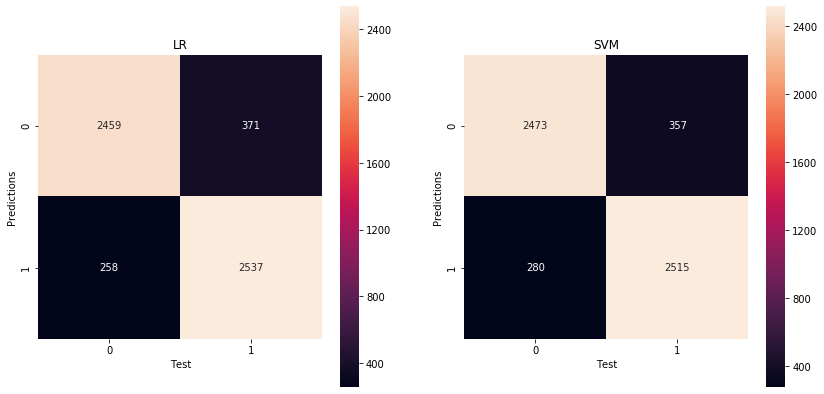

In [36]:
fig, ax = plt.subplots(1, 2, figsize=[14,7])

sns.heatmap(lr_cm, ax=ax[0], annot=True, fmt='d', square=True)
ax[0].set_title('LR')
ax[0].set_xlabel('Test')
ax[0].set_ylabel('Predictions')

sns.heatmap(svm_cm, ax=ax[1], annot=True, fmt='d', square=True)
ax[1].set_title('SVM')
ax[1].set_xlabel('Test')
ax[1].set_ylabel('Predictions')

plt.show()

# Optimization

## Parameter Tuning with GridSearchCV
We find the best **C** and **n-gram** values for our model.

In an n-gram vector, text is represented as a collection of unique n-grams: groups of n adjacent tokens (typically, words). Consider the text The mouse ran up the clock. Here, the word unigrams (n = 1) are ['the', 'mouse', 'ran', 'up', 'clock'], the word bigrams (n = 2) are ['the mouse', 'mouse ran', 'ran up', 'up the', 'the clock'], and so on.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

In [38]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([ 
                      ('tfidf', TfidfVectorizer(tokenizer=tokenizer)),
                      ('classifier', LogisticRegression()),  
                    ])

parameters = {
              'tfidf__ngram_range': [(1,1), (1,2), (1,3)],
              'classifier__C': (0.1, 1, 1.5, 2, 2.5, 3, 3.5, 4, 5),
             }

grid = GridSearchCV(pipeline, cv=10, param_grid=parameters)
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                        

In [39]:
# summarize results
print("\nBest Model: %f using %s" % (grid.best_score_, grid.best_params_))
print('\n')
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean: %f Stdev:(%f) with: %r" % (mean, stdev, param))


Best Model: 0.893689 using {'classifier__C': 5, 'tfidf__ngram_range': (1, 2)}


Mean: 0.852741 Stdev:(0.009266) with: {'classifier__C': 0.1, 'tfidf__ngram_range': (1, 1)}
Mean: 0.842370 Stdev:(0.007996) with: {'classifier__C': 0.1, 'tfidf__ngram_range': (1, 2)}
Mean: 0.835081 Stdev:(0.006588) with: {'classifier__C': 0.1, 'tfidf__ngram_range': (1, 3)}
Mean: 0.884207 Stdev:(0.009068) with: {'classifier__C': 1, 'tfidf__ngram_range': (1, 1)}
Mean: 0.882074 Stdev:(0.009030) with: {'classifier__C': 1, 'tfidf__ngram_range': (1, 2)}
Mean: 0.874548 Stdev:(0.006880) with: {'classifier__C': 1, 'tfidf__ngram_range': (1, 3)}
Mean: 0.885511 Stdev:(0.009229) with: {'classifier__C': 1.5, 'tfidf__ngram_range': (1, 1)}
Mean: 0.886222 Stdev:(0.009037) with: {'classifier__C': 1.5, 'tfidf__ngram_range': (1, 2)}
Mean: 0.878044 Stdev:(0.007564) with: {'classifier__C': 1.5, 'tfidf__ngram_range': (1, 3)}
Mean: 0.886696 Stdev:(0.009150) with: {'classifier__C': 2, 'tfidf__ngram_range': (1, 1)}
Mean: 0.888948 St

## Experiment #1: Lemmatization vs Stemming

We make an experiment between lemmatization and stemming to see which one contribute to a better accuracy for our model.

**Stemming** usually refers to a crude heuristic process that chops off the ends of words in the hope of achieving this goal correctly most of the time, and often includes the removal of derivational affixes.

**Lemmatization** usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma

For instance:

* The word "better" has "good" as its lemma. This link is missed by stemming, as it requires a dictionary look-up.
* The word "walk" is the base form for word "walking", and hence this is matched in both stemming and lemmatisation.
* The word "meeting" can be either the base form of a noun or a form of a verb ("to meet") depending on the context, e.g., "in our last meeting" or "We are meeting again tomorrow". Unlike stemming, lemmatisation can in principle select the appropriate lemma depending on the context.


### Lemmatization: Preprocessing

In [40]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [41]:
def preprocessor_lemma(text):
  text = clean_text(text)
  
  # Lemmatizing
  text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
  text = [lemmatizer.lemmatize(token, "v") for token in text]
  
  # Remove stop words
  text = [word for word in text if not word in stop_words]
  
  text = " ".join(text)
  
  return text

In [42]:
# data.drop(columns='lemma processed review', inplace=True)
data.insert(loc = 2, column="lemma processed review", value="")

In [43]:
data['lemma processed review'] = data['review'].apply(preprocessor_lemma)

In [44]:
data['lemma processed review word count'] = data['lemma processed review'].apply(word_count)
data.head()

,review,stem processed review,lemma processed review,sentiment,word count,stem processed review word count,lemma processed review word count
0,With all this stuff going down at the moment w...,thi stuff go moment mj start listen hi music w...,stuff go moment mj start listen music watch od...,1,433,242,224
1,"\The Classic War of the Worlds\"" by Timothy Hi...",classic war world timothi hine veri entertain ...,classic war world timothy hines entertain film...,1,158,92,85
2,The film starts with a manager (Nicholas Bell)...,film start manag nichola bell give welcom inve...,film start manager nicholas bell give welcome ...,0,378,245,243
3,It must be assumed that those who praised this...,must assum prais thi film greatest film opera ...,must assume praise film greatest film opera ev...,0,379,200,191
4,Superbly trashy and wondrously unpretentious 8...,superbl trashi wondrous unpretenti exploit hoo...,superbly trashy wondrously unpretentious explo...,1,367,223,218


**The lemmatizing review content looks a bit different than the stemming version**

### Lemmatization: Vectorizing, Train - Test Splitting

In [45]:
X_lemma = data['lemma processed review']
X_lemma_train, X_lemma_test, y_lemma_train, y_lemma_test = train_test_split(X_lemma, y, test_size=0.25, random_state=101)

#### Parameter Tuning - Find the best max_features
As the number of features is increasing when using ngram_range, we wonder what is the most optimized number of features. Hence, we perform GridSearchCV to find out.

In [46]:
pipeline1 = Pipeline([ 
                      ('tfidf', TfidfVectorizer(sublinear_tf=True,
                                                tokenizer=tokenizer,
                                                ngram_range=(1, 2))),
                      ('classifier', LogisticRegression()),  
                    ])

parameters = {
              'tfidf__max_features': (20000, 25000, 30000, 40000, 50000, 60000, 70000, 80000)
             }

grid1 = GridSearchCV(pipeline1, cv=10, param_grid=parameters)
grid1.fit(X_lemma_train, y_lemma_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 2),
                                        

In [47]:
# summarize results
print("\nBest Model: %f using %s" % (grid1.best_score_, grid1.best_params_))
print('\n')
means = grid1.cv_results_['mean_test_score']
stds = grid1.cv_results_['std_test_score']
params = grid1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean: %f Stdev:(%f) with: %r" % (mean, stdev, param))


Best Model: 0.893333 using {'tfidf__max_features': 20000}


Mean: 0.893333 Stdev:(0.008175) with: {'tfidf__max_features': 20000}
Mean: 0.892504 Stdev:(0.008255) with: {'tfidf__max_features': 25000}
Mean: 0.892859 Stdev:(0.008553) with: {'tfidf__max_features': 30000}
Mean: 0.892444 Stdev:(0.007638) with: {'tfidf__max_features': 40000}
Mean: 0.892504 Stdev:(0.006928) with: {'tfidf__max_features': 50000}
Mean: 0.892385 Stdev:(0.007139) with: {'tfidf__max_features': 60000}
Mean: 0.891970 Stdev:(0.006902) with: {'tfidf__max_features': 70000}
Mean: 0.892089 Stdev:(0.006724) with: {'tfidf__max_features': 80000}


We can see that **25000 features is the best performer**, so more features doesn't guarantee better performance.

#### Vectorizing

In [66]:
X_lemma = data['review']

t0 = time.time()
tfidf_lemma = TfidfVectorizer(sublinear_tf=True,
                              preprocessor=preprocessor_lemma,
                              tokenizer=tokenizer,
                              ngram_range=(1, 2),
                              max_features= 20000
                             )
X_tfidf_lemma = tfidf_lemma.fit_transform(X_lemma)
t1 = time.time()

X_train_tfidf_lemma, X_test_tfidf_lemma, y_train_tfidf_lemma, y_test_tfidf_lemma = train_test_split(X_tfidf_lemma, y, test_size=0.25, random_state=101)
t2 = time.time()

time_vectorizing_lemma = t1-t0
time_splitting_lemma = t2-t1

print("Vectorizing time: %fs; Splitting time: %fs" % (time_vectorizing_lemma, time_splitting_lemma))

Vectorizing time: 80.169537s; Splitting time: 0.049630s


### Lemmatization: Model training and evaluation

In [67]:
lr_lemma = LogisticRegression(C=5)
t0 = time.time()

lr_lemma.fit(X_train_tfidf_lemma, y_train_tfidf_lemma)
t1 = time.time()

lr_lemma_preds = lr_lemma.predict(X_test_tfidf_lemma)
t2 = time.time()

time_linear_train_lr_lemma = t1-t0
time_linear_predict_lr_lemma = t2-t1

# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train_lr_lemma, time_linear_predict_lr_lemma))

lr_lemma_cm = confusion_matrix(y_test_tfidf_lemma, lr_lemma_preds)
lr_lemma_report = classification_report(y_test_tfidf_lemma, lr_lemma_preds)

Training time: 1.052313s; Prediction time: 0.003035s


In [68]:
print(lr_lemma_cm)
print(lr_lemma_report)

[[2517  313]
 [ 245 2550]]
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      2830
           1       0.89      0.91      0.90      2795

    accuracy                           0.90      5625
   macro avg       0.90      0.90      0.90      5625
weighted avg       0.90      0.90      0.90      5625



### Stemming: Train model using tuned parameters

In [69]:
X_stem = data['review']

t0 = time.time()
tfidf_stem = TfidfVectorizer(sublinear_tf=True,
                              preprocessor=preprocessor_stem,
                              tokenizer=tokenizer,
                              ngram_range=(1, 2),
                              max_features= 20000
                             )
X_tfidf_stem = tfidf_stem.fit_transform(X_stem)
t1 = time.time()

X_train_tfidf_stem, X_test_tfidf_stem, y_train_tfidf_stem, y_test_tfidf_stem = train_test_split(X_tfidf_stem, y, test_size=0.25, random_state=101)
t2 = time.time()

time_vectorizing_lr_stem = t1-t0
time_splitting_lr_stem = t2-t1

print("Vectorizing time: %fs; Splitting time: %fs" % (time_vectorizing_lr_stem, time_splitting_lr_stem))

lr_stem = LogisticRegression(C=5)
t0 = time.time()

lr_stem.fit(X_train_tfidf_stem, y_train_tfidf_stem)
t1 = time.time()

lr_stem_preds = lr_stem.predict(X_test_tfidf_stem)
t2 = time.time()

time_linear_train_lr_stem = t1-t0
time_linear_predict_lr_stem = t2-t1

# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train_lr_stem, time_linear_predict_lr_stem))

lr_stem_cm = confusion_matrix(y_test_tfidf_stem, lr_stem_preds)
lr_stem_report = classification_report(y_test_tfidf_stem, lr_stem_preds)

Vectorizing time: 137.475525s; Splitting time: 0.052015s
Training time: 1.072892s; Prediction time: 0.003054s


In [70]:
print(lr_stem_cm)
print(lr_stem_report)

[[2515  315]
 [ 234 2561]]
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      2830
           1       0.89      0.92      0.90      2795

    accuracy                           0.90      5625
   macro avg       0.90      0.90      0.90      5625
weighted avg       0.90      0.90      0.90      5625



### Validating using K-Fold CV
Finally, to make sure that our train models are not biased by the dataset, we use K-Fold CV to validate them.

In [53]:
lr_lemma_scores = cross_val_score(lr_lemma, X_train_tfidf_lemma, y_train_tfidf_lemma, cv=10)

In [54]:
lr_stem_scores = cross_val_score(lr_stem, X_train_tfidf_stem, y_train_tfidf_stem, cv=10)

In [55]:
lr_lemma_scores.mean()

0.8989026630988233

In [56]:
lr_stem_scores.mean()

0.8992591313845623

### Conclusion
Lemmatization improves our model over Stemming, but not significantly.

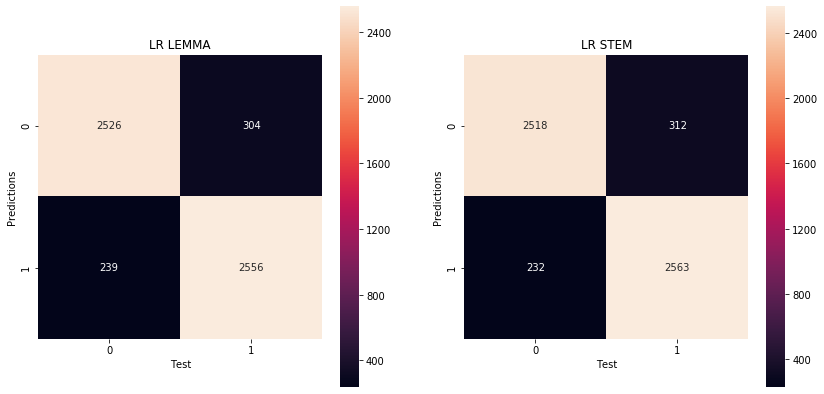

In [57]:
fig, ax = plt.subplots(1, 2, figsize=[14,7])

sns.heatmap(lr_lemma_cm, ax=ax[0], annot=True, fmt='d', square=True)
ax[0].set_title('LR LEMMA')
ax[0].set_xlabel('Test')
ax[0].set_ylabel('Predictions')

sns.heatmap(lr_stem_cm, ax=ax[1], annot=True, fmt='d', square=True)
ax[1].set_title('LR STEM')
ax[1].set_xlabel('Test')
ax[1].set_ylabel('Predictions')

plt.show()

### Save trained model: tuned mode

In [71]:
pickle.dump(lr_stem, open(os.path.join('models', 'Model_LR_imdb_tuned_stem.pkl'), 'wb'), protocol=4)

In [59]:
svm1 = SVC(kernel='linear', C=6)

t0 = time.time()
svm1.fit(X_train_tfidf_lemma, y_train_tfidf_lemma)
t1 = time.time()

svm1_preds = svm1.predict(X_test_tfidf_lemma)
t2 = time.time()

time_svm_train1 = t1-t0
time_svm_predict1 = t2-t1

# results
print("Training time: %fs; Prediction time: %fs" % (time_svm_train1, time_svm_predict1))

svm1_cm = confusion_matrix(y_test_tfidf_lemma, svm1_preds)
svm1_report = classification_report(y_test_tfidf_lemma, svm1_preds)

Training time: 563.519557s; Prediction time: 42.413131s


In [60]:
print(svm1_cm)
print(svm1_report)

[[2490  340]
 [ 305 2490]]
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      2830
           1       0.88      0.89      0.89      2795

    accuracy                           0.89      5625
   macro avg       0.89      0.89      0.89      5625
weighted avg       0.89      0.89      0.89      5625



## Investigate wrong predictions

In [61]:
wrong_predictions_filter = lr_lemma_preds != y_test_tfidf_lemma

In [62]:
lr_lemma_preds[wrong_predictions_filter]

array([1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,

In [63]:
y_test_tfidf_lemma[wrong_predictions_filter]

12326    0
9471     0
4861     0
18265    0
21806    1
17758    1
1058     1
10983    1
3214     1
21193    0
10950    1
7491     1
15651    0
1739     0
10960    0
7477     1
5399     1
4011     1
14427    0
16160    1
15239    1
2898     1
7961     0
2504     0
17544    1
11488    0
2161     0
10450    1
10292    0
1211     0
        ..
19584    0
2656     1
20097    0
5828     1
15097    1
13645    1
8416     0
14233    1
5712     0
18931    0
13032    0
6774     1
19183    1
7732     1
12875    0
8377     1
11396    0
9170     0
15366    1
9391     0
15552    1
15172    1
12712    0
16926    0
6459     0
14337    1
19192    0
10009    1
250      1
16577    0
Name: sentiment, Length: 543, dtype: int64

In [64]:
y_test_tfidf_lemma[wrong_predictions_filter].index

Int64Index([12326,  9471,  4861, 18265, 21806, 17758,  1058, 10983,  3214,
            21193,
            ...
            15552, 15172, 12712, 16926,  6459, 14337, 19192, 10009,   250,
            16577],
           dtype='int64', length=543)

In [65]:
index = 0
print('Predictions:', lr_lemma_preds[wrong_predictions_filter][index])
print('Actual:', y_test_tfidf_lemma[wrong_predictions_filter].iloc[index])
print('Actual Index:', y_test_tfidf_lemma[wrong_predictions_filter].index[index])
print('Review:', data.iloc[y_test_tfidf_lemma[wrong_predictions_filter].index[index]]['lemma processed review'])

Predictions: 1
Actual: 0
Actual Index: 12326
Review: know one care film historic one reason unity two hero two great seventy sci fi film well one great one quite bad great one truly great fact best bad one truly bad fact worst course great refer star war star mark hamill aka luke skywalker hero film kid get vette swipe go vega lead whole lot adventure eventually recover since fix car guess call lube skywalker along way meet hooker heart gold end face character play kim milford hero seventy sci fi cult film laserblast hint earlier worst sci fi film ever make milford play lead baddie hamill must steal car back realize one care meet two great sci fi hero also must say one best worst movie time mark hamill act need force plot need extensive jedi train character hooker play annie potts might annoy character time ever film ever see fun movie watch weekend day weekday night late night late one film meander look something without quite find yet time entire purpose like free form jazz simply ex

## TODO: Implement Light GBM

## TODO: Conclusion